<img src="https://devra.ai/analyst/notebook/1801/image.jpg" style="width: 100%; height: auto;" />

# Table of Contents

- [Imports and Settings](#Imports-and-Settings)
- [Data Loading and Exploration](#Data-Loading-and-Exploration)
- [Data Cleaning and Preprocessing](#Data-Cleaning-and-Preprocessing)
- [Exploratory Data Analysis (EDA)](#Exploratory-Data-Analysis-(EDA))
- [Building a Predictor (Rating-Classification)](#Building-a-Predictor-(Rating-Classification))
- [Summary and Future Directions](#Summary-and-Future-Directions)

In [1]:
# Importing necessary libraries and suppress warnings
import warnings
warnings.filterwarnings('ignore')
import zipfile

import numpy as np
import pandas as pd

import matplotlib
matplotlib.use('Agg')  # Use Agg backend for matplotlib if needed
import matplotlib.pyplot as plt
plt.switch_backend('Agg')  # In case only plt is imported

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc

# Ensure inline plotting in Kaggle notebooks
%matplotlib inline

# Let us set a general aesthetic for our plots
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

In [2]:
# Load the datasets
def get_dataset(filename=None,encoding='ascii'):
    zip_path = 'data/ml-latest1m.zip'
    
    with zipfile.ZipFile(zip_path, 'r') as z:
        with z.open(filename) as f:
            dataset_df = pd.read_csv(f,encoding=encoding)
    return dataset_df
    # Optional: drop timestamp for cleaner format
    # ratings_df = ratings_df[["user_id", "movie_id", "user_rating"]]
    # Rename columns to match your desired format
    # ratings_df = ratings_df.rename(columns={
    #      "user_id":"userId",
    #      "movie_id":"movieId",
    #      "user_rating":"rating" 
    # })
    # return ratings_df

users_df = get_dataset('users.csv', encoding='ascii')
ratings_df = get_dataset('ratings.csv', encoding='ascii')
movies_df = get_dataset('movies.csv', encoding='ISO-8859-1')

# Print the shapes of the dataframes (this output is not shown in the final run output)
print('Users:', users_df.shape)
print('Ratings:', ratings_df.shape)
print('Movies:', movies_df.shape)

Users: (6040, 6)
Ratings: (1000209, 4)
Movies: (3706, 4)


## Data Loading and Exploration

Before diving into the cleaning process and analysis, it is informative to peek at the structure of the data. We have three primary files:

- users.csv: Contains user information such as age, occupation, and gender.
- ratings.csv: Contains movie ratings by users along with a timestamp that is in Unix time format.
- movies.csv: Contains movie metadata including titles, genres, and poster URLs.

Let us look at a few rows from each file.

In [3]:
# Display the first few rows of each dataframe (in actual use, these outputs would reveal sample data)
print('---- Users ----')
print(users_df.head())

print('\n---- Ratings ----')
print(ratings_df.head())

print('\n---- Movies ----')
print(movies_df.head())

# Also, print basic info to understand data types
print('\nUsers Info')
print(users_df.info())

print('\nRatings Info')
print(ratings_df.info())

print('\nMovies Info')
print(movies_df.info())

---- Users ----
   user_id  user_gender  bucketized_user_age  user_occupation_label  \
0      130         True                 35.0                     18   
1     3829        False                 25.0                      0   
2     1265        False                 18.0                     21   
3     2896         True                 18.0                     14   
4     5264         True                 18.0                     17   

   user_occupation_text user_zip_code  
0   technician/engineer         50021  
1     academic/educator         22307  
2                writer         49321  
3       sales/marketing         60073  
4  college/grad student         15217  

---- Ratings ----
   user_id  movie_id  user_rating   timestamp
0      130      3107          5.0   977432193
1     3829      2114          4.0   965932967
2     1265       256          1.0  1012103552
3     2896      1389          5.0   972004605
4     5264      3635          4.0   961180111

---- Movies ----
   m

## Data Cleaning and Preprocessing

In this section we perform necessary cleaning and preprocessing steps:

- Convert the Unix timestamp in ratings to a datetime object
- Merge the datasets to form a comprehensive dataframe for analysis

Note: Converting timestamps not only makes it easier to understand the data but also prevents errors when performing date-based analyses. Similar issues may be encountered by other notebook creators working with timestamp data.

In [4]:
# Convert Unix timestamp to datetime in ratings
ratings_df['timestamp'] = pd.to_datetime(ratings_df['timestamp'], unit='s')

# Merge the datasets into a single dataframe for combined analysis
merged_df = ratings_df.merge(users_df, on='user_id', how='left').merge(movies_df, on='movie_id', how='left')

# Print info of the merged dataframe
print('Merged DataFrame shape:', merged_df.shape)
print(merged_df.info())

Merged DataFrame shape: (1000209, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 12 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   user_id                1000209 non-null  int64         
 1   movie_id               1000209 non-null  int64         
 2   user_rating            1000209 non-null  float64       
 3   timestamp              1000209 non-null  datetime64[ns]
 4   user_gender            1000209 non-null  bool          
 5   bucketized_user_age    1000209 non-null  float64       
 6   user_occupation_label  1000209 non-null  int64         
 7   user_occupation_text   1000209 non-null  object        
 8   user_zip_code          1000209 non-null  object        
 9   movie_title            1000209 non-null  object        
 10  movie_genres           1000209 non-null  object        
 11  poster_url             993655 non-null   object    

## Exploratory Data Analysis (EDA)

Now for some exploratory data analysis to understand the distributions and relationships in the data. We apply multiple visualization methods including histograms, count plots, pair plots, box plots and a correlation heatmap where applicable.

We note that while the timestamp is now a datetime object, for correlation analysis, we temporarily use the original numeric columns in the ratings dataframe.

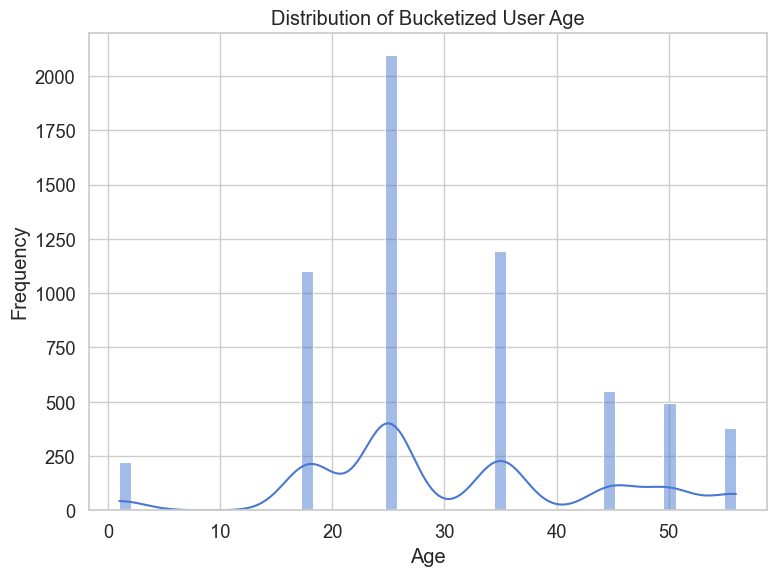

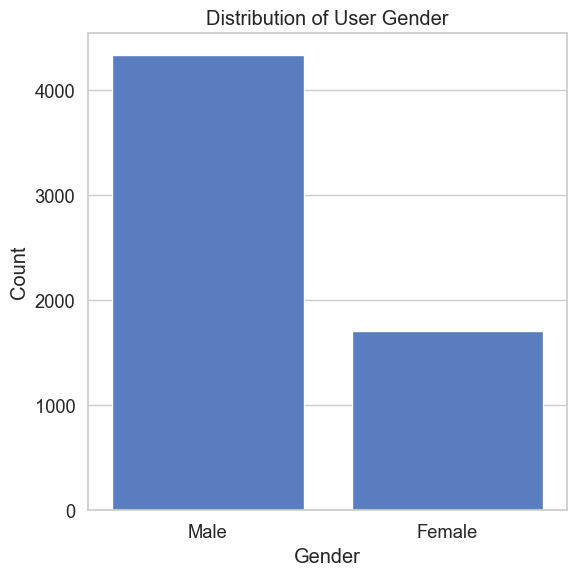

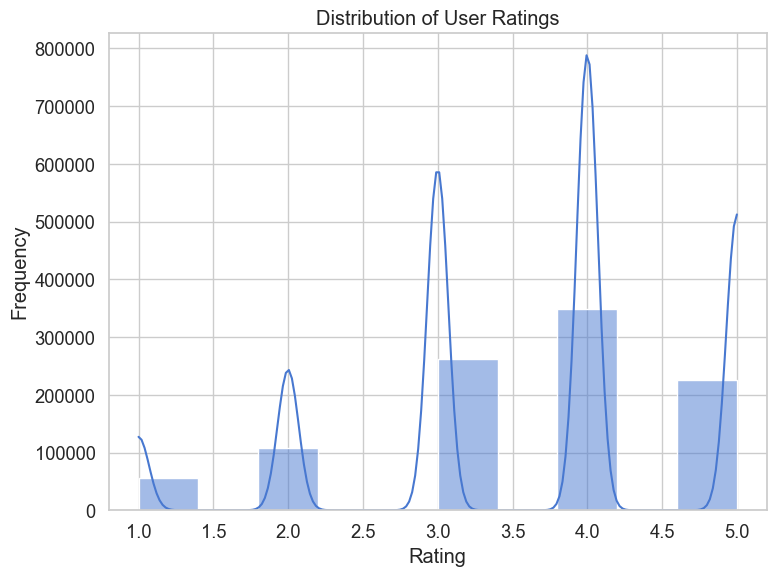

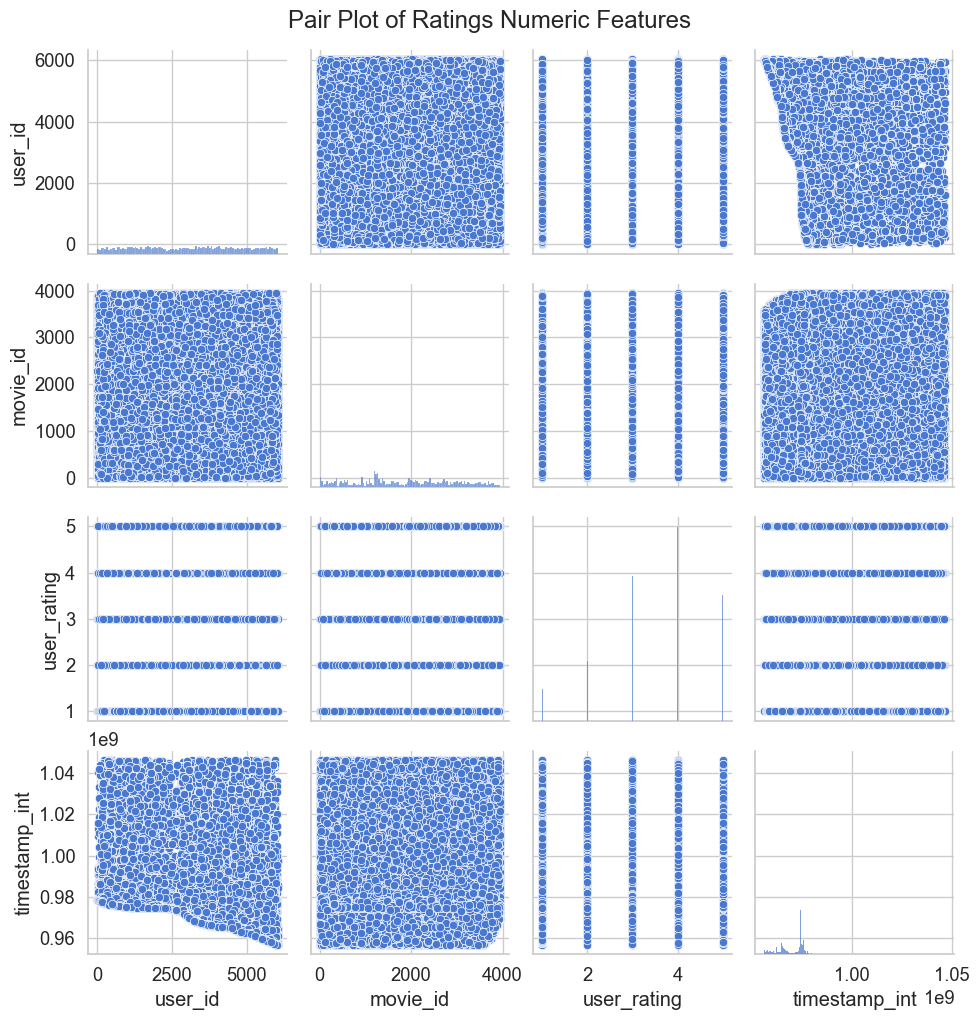

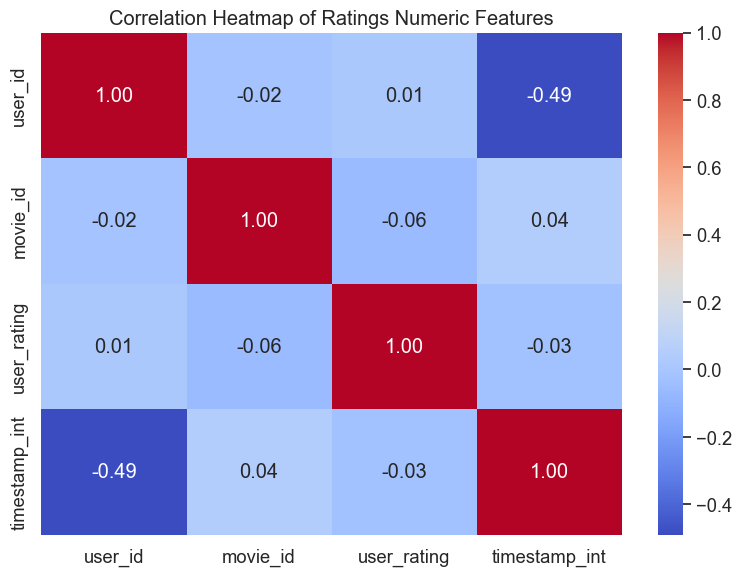

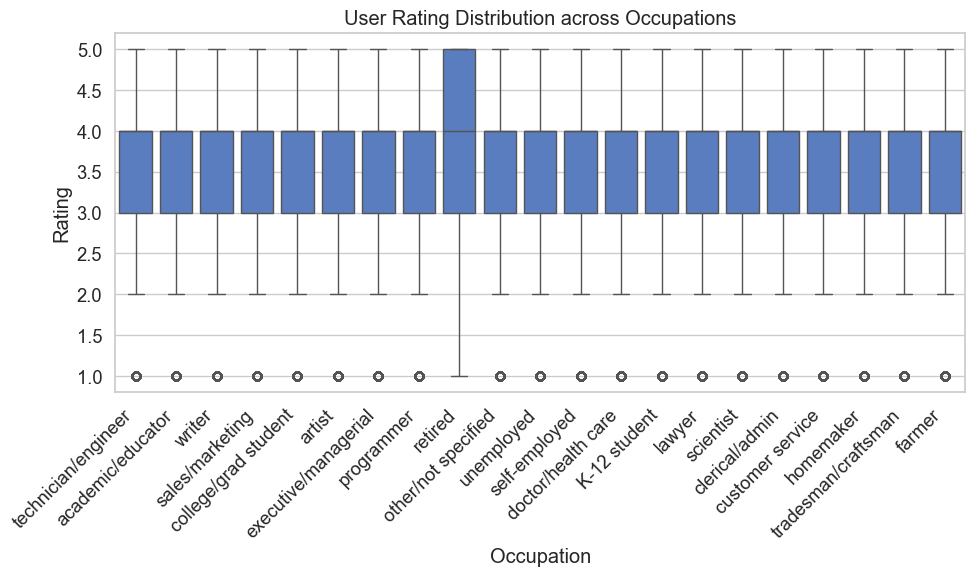

In [5]:
# Histogram for user age from the users dataset
plt.figure(figsize=(8, 6))
sns.histplot(users_df['bucketized_user_age'], kde=True)
plt.title('Distribution of Bucketized User Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Pie Chart style countplot for gender distribution (Since the gender column is boolean, we convert it to string for better labeling)
users_df['user_gender_str'] = users_df['user_gender'].apply(lambda x: 'Male' if x else 'Female')
plt.figure(figsize=(6, 6))
sns.countplot(x='user_gender_str', data=users_df)
plt.title('Distribution of User Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Distribution of user ratings
plt.figure(figsize=(8, 6))
sns.histplot(merged_df['user_rating'], bins=10, kde=True)
plt.title('Distribution of User Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Pair Plot for a subset of numeric features in ratings_df (using the original numeric columns)
pairplot_cols = ['user_id', 'movie_id', 'user_rating']
# We add timestamp as numeric by converting it back to integer (not used further) for demonstration
ratings_df['timestamp_int'] = ratings_df['timestamp'].astype(np.int64) // 10**9  
pairplot_cols.append('timestamp_int')
sns.pairplot(ratings_df[pairplot_cols])
plt.suptitle('Pair Plot of Ratings Numeric Features', y=1.02)
plt.show()

# Correlation Heatmap on ratings dataframe (only if there are 4 or more numeric columns)
numeric_df = ratings_df.select_dtypes(include=[np.number])
if numeric_df.shape[1] >= 4:
    plt.figure(figsize=(8, 6))
    corr = numeric_df.corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Heatmap of Ratings Numeric Features')
    plt.tight_layout()
    plt.show()
else:
    print('Not enough numeric columns for a correlation heatmap.')

# Box Plot to compare rating distributions across user occupations
plt.figure(figsize=(10, 6))
sns.boxplot(x='user_occupation_text', y='user_rating', data=merged_df)
plt.title('User Rating Distribution across Occupations')
plt.xlabel('Occupation')
plt.ylabel('Rating')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Building a Predictor (Rating-Classification)

The data may imply that predicting whether a user gives a high or low rating is a useful exercise. We create a binary target variable based on the rule: ratings equal to or above 4 are labeled as 1 (high rating), otherwise 0 (low rating).

We use a basic Logistic Regression model to predict this outcome. The performance of this predictor is measured via accuracy score, confusion matrix, and an ROC curve.

Note: This is a baseline model. Future analysis could explore more complex feature engineering and different classification algorithms.

Accuracy of the Logistic Regression model: 0.5760


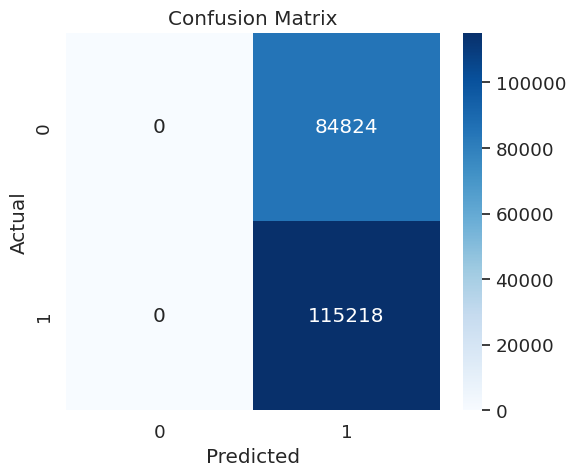

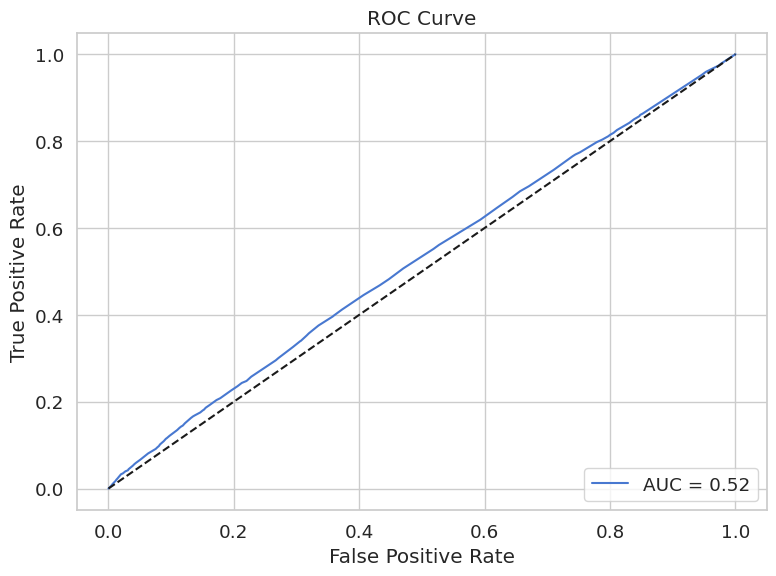

In [6]:
# Create a binary target variable: 1 if rating >= 4, else 0
merged_df['high_rating'] = merged_df['user_rating'].apply(lambda x: 1 if x >= 4 else 0)

# For simplicity, select a few features to predict high_rating
# In practice, selecting features is a key step
features = ['bucketized_user_age', 'user_occupation_label']
X = merged_df[features].copy()
y = merged_df['high_rating']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build a logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy of the Logistic Regression model: {accuracy:.4f}')

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# ROC Curve
y_probs = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

## Summary and Future Directions

In this notebook we:

- Loaded and inspected data from MovieLens including users, ratings, and movies.
- Cleaned the data by transforming Unix timestamps into datetime objects and merging datasets for a comprehensive view.
- Performed extensive exploratory data analysis using multiple visualization methods such as histograms, box plots, pair plots, and correlation heatmaps.
- Built a baseline Logistic Regression predictor to classify high ratings based on user age and occupation, evaluating performance with accuracy, a confusion matrix, and an ROC curve.

Future analysis could include:

- More sophisticated feature engineering, for example, incorporating movie genres or time trends.
- Exploring alternative predictive models, including ensemble methods.
- A deeper dive into user behavior segmentation.

Thanks for reading. If you found the notebook useful, please consider upvoting it.